<a href="https://colab.research.google.com/github/karmanandan/Deep_learning_projects/blob/master/RCNN_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
RCNN
# It is computationally heavy
1. Pass the image through selective search and generate region proposal.
2.Calculate IOU (intersection over union) on proposed region with ground truth data and add label to the proposed regions.
3. Do transfer learning using the proposed regions with the labels.
4. Pass the test image to selective search and then pass the first 2000 proposed
 regions from the trained model and predict the class of those regions.
'''

In [ ]:
!git clone https://github.com/1297rohit/RCNN.git

Cloning into 'RCNN'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 19
Unpacking objects: 100% (25/25), done.


In [ ]:
import os
os.chdir('/content/RCNN')

In [ ]:
!unzip Images.zip
!unzip Airplanes_Annotations.zip

Archive:  Images.zip
   creating: Images/
  inflating: Images/airplane_007.jpg  
  inflating: Images/airplane_006.jpg  
  inflating: Images/airplane_005.jpg  
  inflating: Images/airplane_004.jpg  
  inflating: Images/airplane_003.jpg  
  inflating: Images/airplane_002.jpg  
  inflating: Images/airplane_001.jpg  
  inflating: Images/428503.jpg       
  inflating: Images/428501.jpg       
  inflating: Images/428492.jpg       
  inflating: Images/428491.jpg       
  inflating: Images/428483.jpg       
  inflating: Images/428482.jpg       
  inflating: Images/428481.jpg       
  inflating: Images/428472.jpg       
  inflating: Images/428462.jpg       
  inflating: Images/428461.jpg       
  inflating: Images/428452.jpg       
  inflating: Images/428451.jpg       
  inflating: Images/42850.jpg        
  inflating: Images/42849.jpg        
  inflating: Images/42848.jpg        
  inflating: Images/42847.jpg        
  inflating: Images/airplane_309.jpg  
  inflating: Images/airplane_319.jpg  

In [ ]:
import cv2
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
images_path = 'Images'
annot_path = 'Airplanes_Annotations'

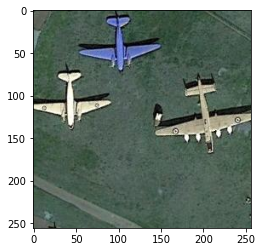

In [ ]:
filename = 'airplane_096.jpg'
img = cv2.imread(os.path.join(images_path,filename))
plt.imshow(img);

airplane_025.csv
filename: airplane_025.jpg


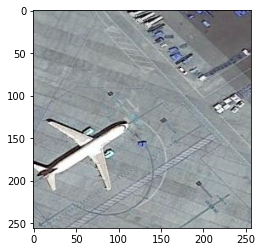

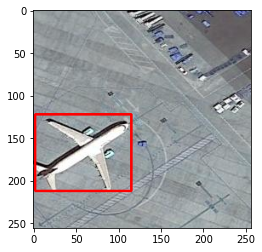

In [ ]:
for e,i in enumerate(os.listdir(annot_path)):
  if e==56:
    print(i)
    filename = i.split(".")[0]+".jpg"
    print('filename:',filename)
    img = cv2.imread(os.path.join(images_path,filename))
    df = pd.read_csv(os.path.join(annot_path,i))
    plt.imshow(img)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

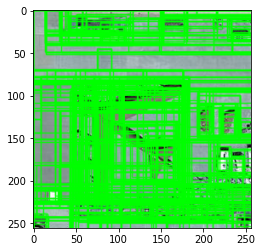

In [ ]:
im = cv2.imread(os.path.join(images_path,"airplane_095.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
for e,i in enumerate(os.listdir(annot_path)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(images_path,filename))
            df = pd.read_csv(os.path.join(annot_path,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_144.jpg
1 airplane_469.jpg
inside
2 airplane_079.jpg
3 airplane_687.jpg
4 airplane_360.jpg
5 airplane_414.jpg
6 airplane_086.jpg
7 airplane_516.jpg
8 airplane_168.jpg
9 airplane_053.jpg
inside
10 airplane_365.jpg
12 airplane_325.jpg
13 airplane_413.jpg
14 airplane_331.jpg
15 airplane_029.jpg
16 airplane_568.jpg
inside
17 airplane_257.jpg
18 airplane_392.jpg
19 airplane_455.jpg
20 airplane_031.jpg
21 airplane_125.jpg
22 airplane_033.jpg
23 airplane_446.jpg
24 airplane_550.jpg
25 airplane_239.jpg
26 airplane_618.jpg
27 airplane_260.jpg
28 airplane_344.jpg
29 airplane_215.jpg
30 airplane_027.jpg
31 airplane_501.jpg
32 airplane_297.jpg
inside
33 airplane_205.jpg
34 airplane_621.jpg
inside
35 airplane_677.jpg
36 airplane_555.jpg
inside
37 airplane_303.jpg
38 airplane_449.jpg
39 airplane_304.jpg
40 airplane_165.jpg
41 airplane_187.jpg
42 airplane_458.jpg
43 airplane_112.jpg
inside
44 airplane_140.jpg
45 airplane_511.jpg
46 airplane_614.jpg
47 airplane_447.jpg
48 airplane_691.jpg
5

In [ ]:
X_new = np.array(train_images)[:5000]
y_new = np.array(train_labels)[:5000]

In [ ]:
X_new.shape

(5000, 224, 224, 3)

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 11s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
X= vggmodel.layers[-2].output

In [ ]:
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(vggmodel.input,predictions)

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tf.keras.utils.plot_model(model_final)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4500, 224, 224, 3) (500, 224, 224, 3) (4500, 2) (500, 2)


In [ ]:
# trdata = ImageDataGenerator(horizontal_flip=True)
# traindata = trdata.flow(x=X_train, y=y_train)
# tsdata = ImageDataGenerator(horizontal_flip=True)
# # horizontal_flip=True, vertical_flip=True, rotation_range=90
# testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
import tensorflow
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical

## Transforming labels to correct format
train_labels = to_categorical(y_train, num_classes=5)
test_labels = to_categorical(y_test, num_classes=5)


## Preprocessing input
train_ds = preprocess_input(X_train) 
test_ds = preprocess_input(X_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                      verbose=1, mode='auto')

In [ ]:
# hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10,
#                                  epochs= 10, validation_data= testdata,
#                                  validation_steps=2)
# ,
#                                  callbacks=[checkpoint,early]


#################

hist = model_final.fit(train_ds, train_labels, epochs=50, validation_split=0.2,
                       batch_size=32, callbacks=[checkpoint,early])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [ ]:
im = X_test[1600]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

In [ ]:
z=0
for e,i in enumerate(os.listdir(images_path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(images_path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)